In [176]:
import numpy as np
import pandas as pd
import scipy as sp
import plotly.express as px
import networkx as nx
import degroot as dg
import copy
from tqdm import tqdm
import plotly.graph_objects as go
from tqdm import tqdm
from joblib import Parallel, delayed

In [37]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [365]:
dims = 12
niter_degroot = 2

In [371]:
correct_belief = 0.7
confident_agent = 0.1
other_belief = 0.3
init_beliefs = {
    0: np.random.uniform(correct_belief-confident_agent, correct_belief+confident_agent),
    1: np.random.uniform(correct_belief-confident_agent, correct_belief+confident_agent),
    2: np.random.uniform(0, 1),
    3: np.random.uniform(0, 1),
    4: np.random.uniform(0, 1),
    5: np.random.uniform(0, 1),
    6: np.random.uniform(0, 1),
    7: np.random.uniform(0, 1),
    8: np.random.uniform(0, 1),
    9: np.random.uniform(0, 1),
    10: np.random.uniform(other_belief-confident_agent, correct_belief+confident_agent),
    11: np.random.uniform(other_belief-confident_agent, correct_belief+confident_agent)
}
init_beliefs

{0: 0.6853694426697305,
 1: 0.611889489628133,
 2: 0.9280348949931091,
 3: 0.8572067095363798,
 4: 0.11777706455192727,
 5: 0.7663082065847353,
 6: 0.5069097985011031,
 7: 0.8572468061506258,
 8: 0.5292467803028748,
 9: 0.0011238310029307863,
 10: 0.7067985886606608,
 11: 0.5942962608635738}

(0.141582741318856,
 array([0.60899842, 0.54724586, 0.5459326 , 0.59165146, 0.52863531,
        0.62376009, 0.50463897, 0.55469365, 0.58680227, 0.50463897,
        0.61229872, 0.49171079]))

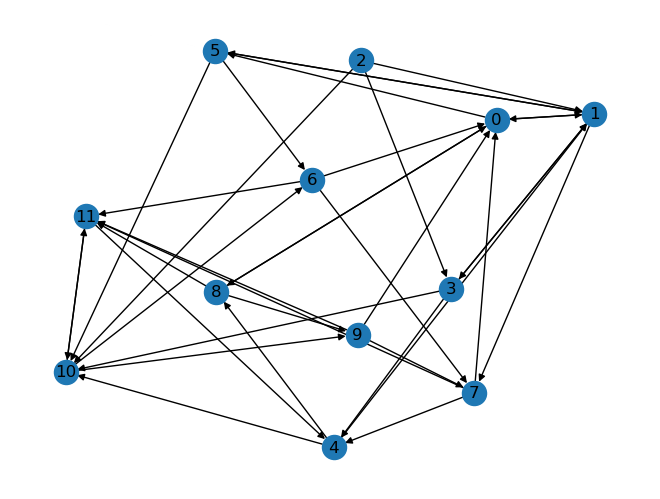

In [372]:
n = nx.DiGraph()
n.add_nodes_from(list(init_beliefs.keys()))
n.add_edges_from([
    (0, 1),
    (0, 5),
    (0, 8),
    (1, 0),
    (1, 3),
    (1, 7),
    (2, 1),
    (2, 10),
    (2, 3),
    (3, 1),
    (3, 10),
    (3, 4),
    (4, 1),
    (4, 10),
    (4, 8),
    (5, 1),
    (5, 10),
    (5, 6),
    (6, 0),
    (6, 11),
    (6, 7),
    (7, 0),
    (7, 11),
    (7, 4),
    (8, 0),
    (8, 11),
    (8, 9),
    (9, 0),
    (9, 11),
    (9, 7),
    (10, 11),
    (10, 6),
    (10, 9),
    (11, 10),
    (11, 4),
    (1, 5),
])
nx.draw(n, with_labels=True)
raw_error, raw_final_belief = dg.degroot_err(nx.adjacency_matrix(n).todense(), np.array(list(init_beliefs.values())), correct_belief, niter_degroot)
raw_error, raw_final_belief

In [373]:
error = []
for i in tqdm(list(range(1000))):
    m0 = nx.adjacency_matrix(n).todense()
    initial_belief = np.array(list(init_beliefs.values()))
    niter_search = 200
    max_edge_values = 3
    res = dg.myopic_search(m0=nx.adjacency_matrix(n).todense(), niter_search=niter_search, max_edge_value=max_edge_values, initial_belief=initial_belief, correct_belief=correct_belief, niter_degroot=niter_degroot)
    error.append({'error': res.error, 'n_improvements': len(res.trajectory)})

error = pd.DataFrame(error)
hist, bins = np.histogram(error['error'], bins=10)
fig = px.bar(x=bins[1:], y=hist, labels={'x':'Error', 'y':'Frequency'})
fig.add_trace(go.Scatter(x=[raw_error], y=[0], mode='markers', marker=dict(size=10, color='red')))

100%|██████████| 1000/1000 [00:24<00:00, 41.24it/s]


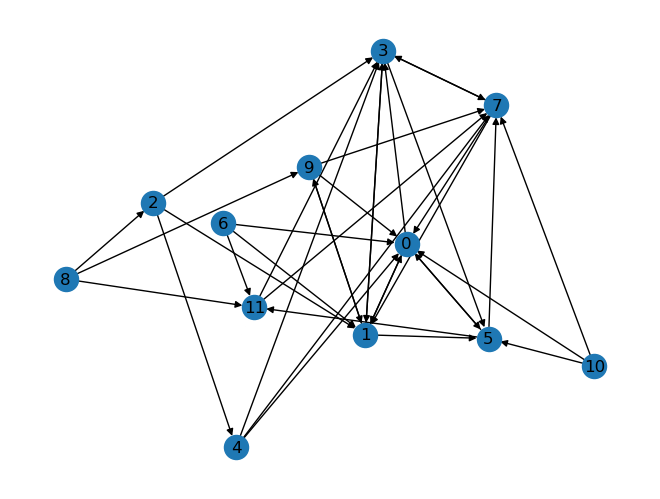

In [369]:
nx.draw(nx.from_numpy_array(res.m, create_using=nx.DiGraph), with_labels=True)

In [370]:
px.scatter(error, x='n_improvements', y='error', trendline='ols')

In [324]:
m0 = nx.adjacency_matrix(n).todense()
initial_belief = np.array(list(init_beliefs.values()))
niter_search = 20
max_edge_values = 5
res = dg.myopic_search(m0=nx.adjacency_matrix(n).todense(), niter_search=niter_search, max_edge_value=max_edge_values, initial_belief=initial_belief, correct_belief=correct_belief, niter_degroot=niter_degroot)

In [175]:
adj = nx.adjacency_matrix(n).todense()
err, final_belief = dg.degroot_err(adj, np.array(list(init_beliefs.values())), correct_belief, niter_degroot)
err, final_belief, np.mean(final_belief)

(0.2893689895113424,
 array([0.43301199, 0.75332526, 0.44801583, 0.70115481, 0.36656734,
        0.39028894, 0.70641156, 0.41702066, 0.5417899 , 0.50986881,
        0.30226368, 0.55785334]),
 0.5106310104886577)

In [109]:
erdos_reni_p = 0.2
errors = []
for i in range(nsim):
    network = nx.erdos_renyi_graph(n=dims, p=erdos_reni_p)
    adj = nx.adjacency_matrix(network).todense()
    err, final_belief = dg.degroot_err(adj, init_belief, correct_belief, niter_degroot)
    errors.append(err)

hist, bins = np.histogram(errors, bins=20) 
print(np.mean(errors), np.std(errors))
px.bar(x=bins[1:], y=hist, labels={'x':'Error', 'y':'Frequency'})

0.17774698672077435 0.05215709160869893


In [110]:
barabasi_albert_m = 2
errors = []
for i in range(nsim):
    network = nx.barabasi_albert_graph(n=dims, m=barabasi_albert_m)
    adj = nx.adjacency_matrix(network).todense()
    err, final_belief = dg.degroot_err(adj, init_belief, correct_belief, niter_degroot)
    errors.append(err)

hist, bins = np.histogram(errors, bins=20) 
print(np.mean(errors), np.std(errors))
px.bar(x=bins[1:], y=hist, labels={'x':'Error', 'y':'Frequency'})

0.22877667329518686 0.02200346110625076


In [104]:
n_cliques = 2
errors = []
for i in range(nsim):
    network = nx.connected_caveman_graph(l=n_cliques, k=dims//n_cliques)
    adj = nx.adjacency_matrix(network).todense()
    err, final_belief = dg.degroot_err(adj, init_belief, correct_belief, niter_degroot)
    errors.append(err)

hist, bins = np.histogram(errors, bins=20) 
print(np.mean(errors), np.std(errors))
px.bar(x=bins[1:], y=hist, labels={'x':'Error', 'y':'Frequency'})

0.021930142608144024 3.469446951953614e-18


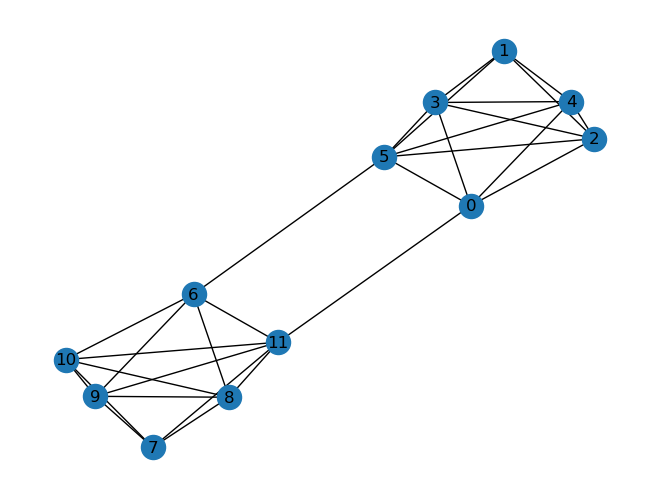

In [102]:
nx.draw(network, with_labels=True)